# lorapy symbol viewer

In [14]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np
from six.moves import cPickle
from tqdm import tqdm_notebook
import warnings 

import matplotlib.pyplot as plt 
# plt.style.use('dark_background')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('../data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
DOTP_DATA_DIR = _BASE_DATA_DIR.joinpath('symbol-ref')
DEV_DATA_DIR = _BASE_DATA_DIR.joinpath('dev-data')
PROC_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('processed-symbols')

# load

In [4]:
def _load_matching_dotp(bw: int, sf: int):
    return ploader.filter(bw=bw, sf=sf)[0]

## files

In [5]:
symloader = lorapy.load_dotp(PROC_SYMBOL_DIR)
symloader.file_list

2020-04-10 08:04:03.165 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: ../data/processed-symbols
2020-04-10 08:04:03.167 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 3 data file(s)


[DotPFile(id=0 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=1 | name='lora_BW9_SF12_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=2 | name='lora_BW9_SF11_915MHz_20ksps_Att60_v0.p')]

In [6]:
symloader.filter()

[DotPFile(id=0 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=1 | name='lora_BW9_SF12_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=2 | name='lora_BW9_SF11_915MHz_20ksps_Att60_v0.p')]

In [7]:
ploader = lorapy.load_dotp(DOTP_DATA_DIR)
ploader.file_list

2020-04-10 08:04:03.201 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: ../data/symbol-ref
2020-04-10 08:04:03.203 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 15 data file(s)


[DotPFile(id=0 | name='lora_BW1_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=1 | name='lora_BW1_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW9_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=3 | name='lora_BW2_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=4 | name='lora_BW9_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=5 | name='lora_BW2_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=6 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=7 | name='lora_BW7_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=8 | name='lora_BW8_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW8_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=10 | name='lora_BW1_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=11 | name='lora_BW2_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=12 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=13 | name='lora_BW7_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=14 | name='lora_BW7_SF11_915MHz_20ksps_Att0_v0.p')]

## symbols

In [23]:
file = symloader.select(0)
file.load()
display(file)

pfile = _load_matching_dotp(file.bw, file.sf)
display(pfile)

2020-04-10 08:10:25.633 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-10 08:10:25.739 | INFO     | lorapy.datafile._base_file:load:61 - loaded 3622400 samples from file


DotPFile(id=0 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.p')

DotPFile(id=12 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p')

In [24]:
symbols = file.to_signal()
symbols

BaselineSymbolSet(num symbols=9056 | BW: 9 | SF: 10 | Att: 100 | samples per symbol: 400 | packet length: 12100)

# visualize

In [25]:
symbols.num_symbols

9056

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


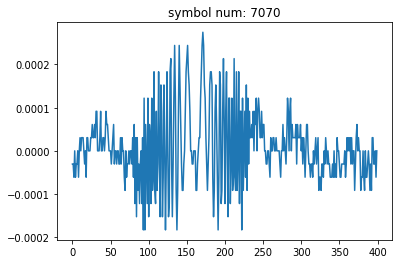

In [26]:
symbols.plot()

batches = 181


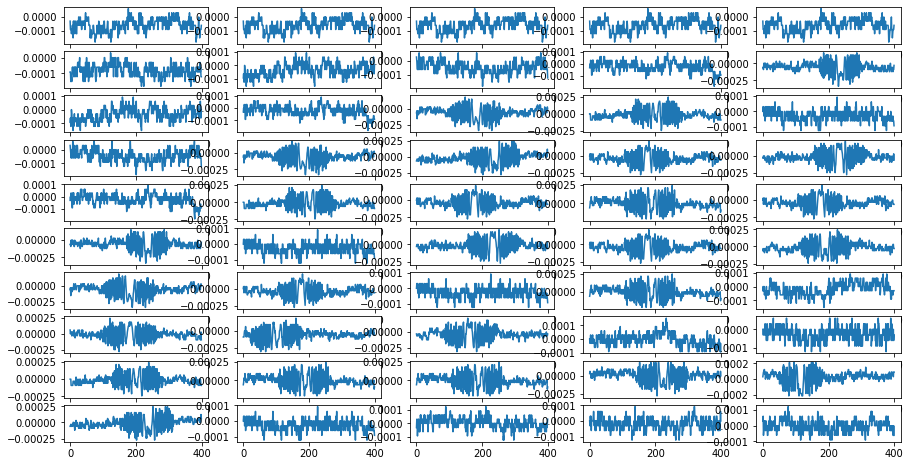

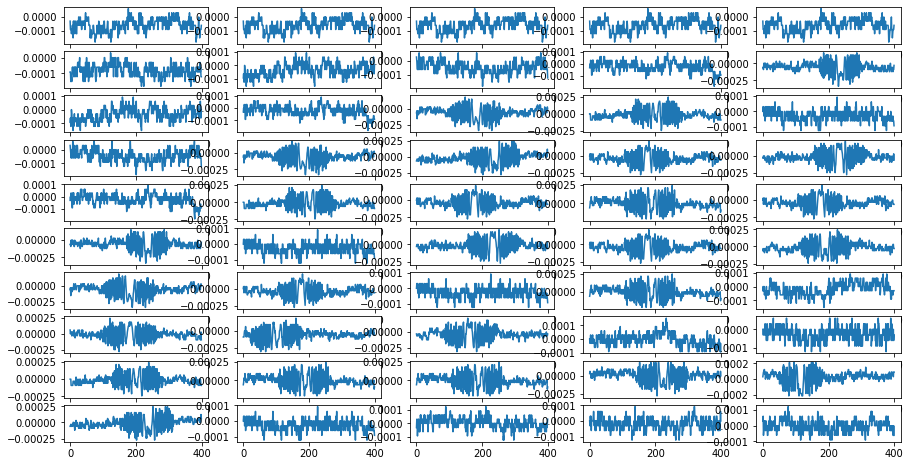

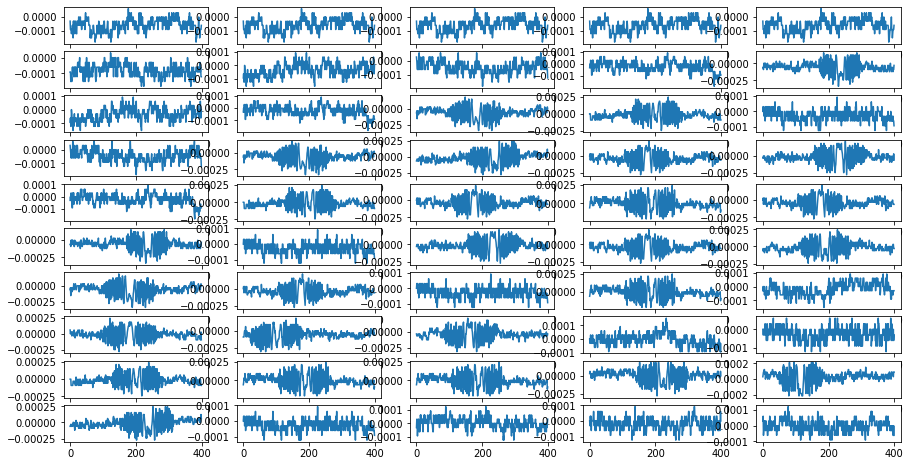

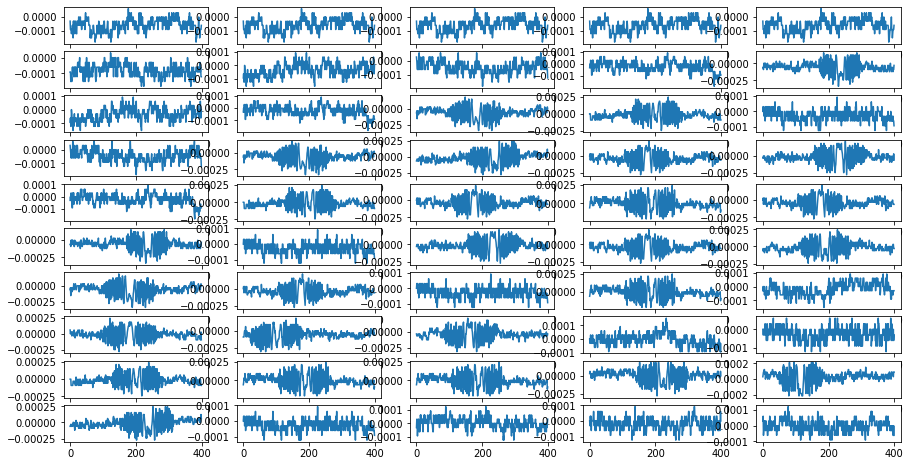

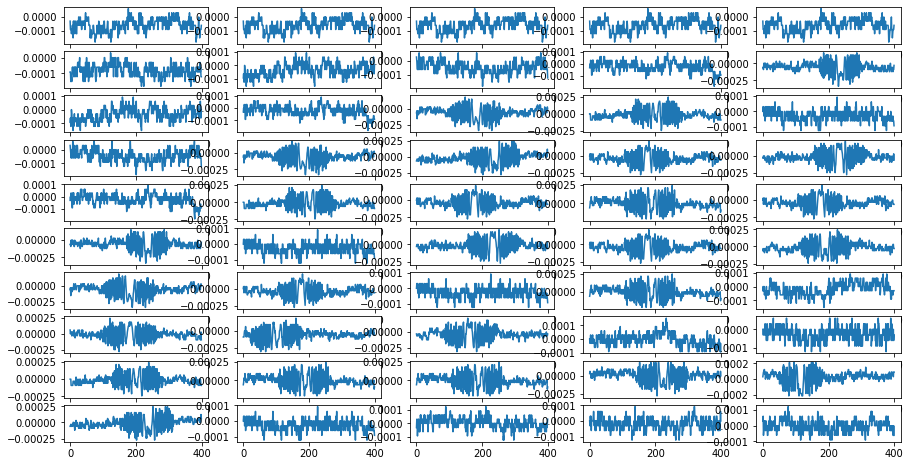

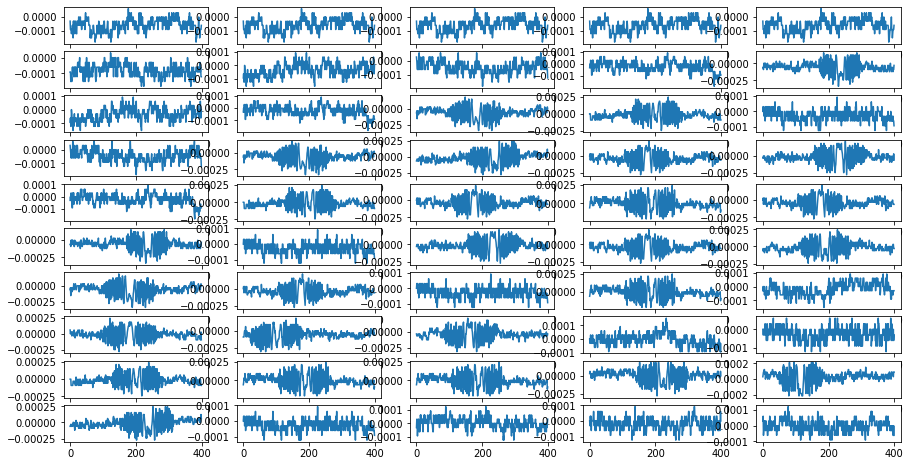

In [27]:
batch_size = 50
batches = symbols.num_symbols // 50
print(f'batches = {batches}')

stop = 0

for _ in range(symbols.num_symbols // 50):
    rows, cols = 10, 5
    fig, ax = plt.subplots(10, 5, figsize=(15,8))
    
    for i in range(rows):
        for j in range(cols):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax[i, j].plot(symbols.data[i + i*j])
            
    stop += 1
    if stop > 5:
        break
    